# Release and Deploy

# Expectations

Better understanding of Code Deploy

# Insights

Most of the examples given in this class are about launching apps on the host "locally," not running containers (They did not go through ECS at all)

The Examples provided instruct you through manually connecting to the EC2 instance to install the CodeDeploy Agent, but there is an option is setting up your instance that would automatically install it for you.

Never seen the [Tree](https://www.geeksforgeeks.org/tree-command-unixlinux/#) command in Linux for visualization of file system

Most yaml type configuration files are a good example of declarative code

# DevOps on AWS

Continuous Delivery: Every code change is built, tested, and then pushed to a non production testing or staging environment.

From there, manual approval is required to push that code to production

Continous Deployment: No manual approval is required, code will automatically deploy to production after the first non production environment

## Deployments

**Deployment Options for VMs:**

1. Replace: Terminate the application in the host, deploy new version to the same hosts  
 Potential downtime in switching but easy to learn and start  
 Rollback by terminating new application, reinstate the old one

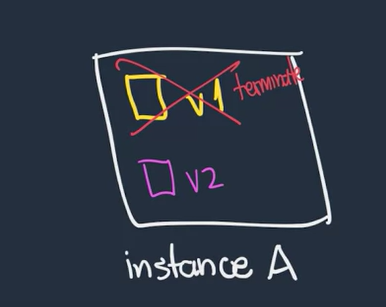


2. Using a load balancer, remove one of the instances from being directed by the balancer, and do the same as option 1. Repeat for all instances.  
 No downtime, but more complex working with multiple instances
 The updated instance is the canary to monitor to see if everything is running smoothly

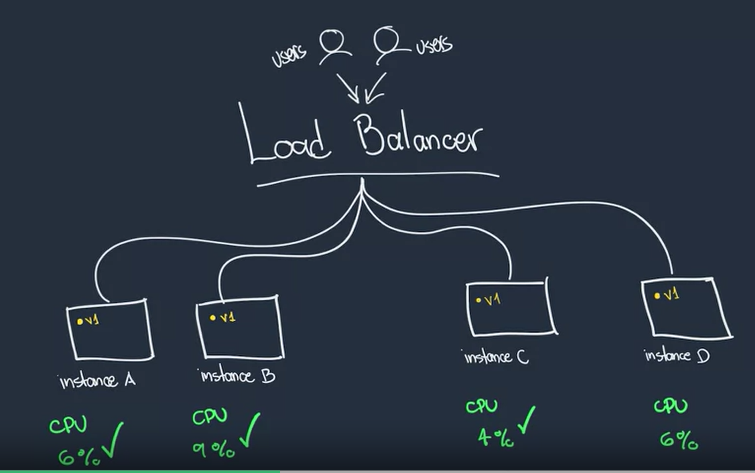

3. Use Blue/Green environments where new instances are spun up from scratch with the new applications installed. Then either the DNS can be switched to point to the new cluster, or the green hosts can be registered on the load balancer, and blue ones are deregistered.

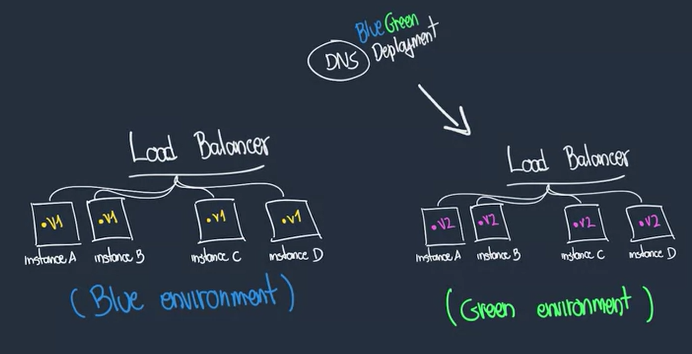

Considerations for different styles of Deployment:

Usually you should have an outside persistent storage for state and/or data, but sometimes applications require that the storage is within the host, such as legacy applications

In Zero Downtime deployments, there will be some point where to versions will run in parallel

**Serverless Terminology (Lambda Functions):**

Versions are snapshots of a function that include the code and configuration

Aliases: have a name and ARN (a pointer, essentially, to be able to ensure your application is always using the latest version)

Traffic Shifting: Essentially a way to load balance between an old and new version. You can use it to gradually shift traffic between two versions.

**Deploying to Compute (EC2, Lambda, etc)**

For AWS there's EC2, on-premise physical servers, AWS Lambda, and AWS ECS.

**For EC2 or On-Prem:**

Deployment Groups will need to know:
* IAM role: to authenticate to other AWS services
* Deployment style: In place or blue green
* Deployment configuration: Number of healthy hosts that should be available for deployment
* How to find the instances: by tags, autoscaling groups, or on-premise tagged instances

Once a Deployment Group is in place, a deployment will require:
 * the application
 * the deployment group
 * a revision of the application

Revision instructions will be in the appspec file, along with hooks to run commands during deployment

The CodeDeploy agent will be running in the instances to ensure that

These artifacts can be hooked up to one another in the CodePipeline, so that the revision can be moved via PipeLine from test to prod, etc



AppSpec File

YAML or JSON file that contains:
 * locations for the installation files
 * scripts
 * when to intitiate specific actions
 * can contain permissions for linux

Hooks direct the CodeDeploy agent as to what it needs to do and in what sequence. Some main hooks include:

* BeforeInstall
* AfterInstall
* ApplicationStart
* ApplicationStop
* ValidateService

Each hook specifies:
* the location of the script
* the timeout for it try to run
* runas is for linux, and specifies if it should be run at root level, a particular user, etc.



In [ ]:
An example of an AppSpec File for Deploying ECS:

version: 0.0
Resources:
  - TargetService:
      Type: AWS::ECS::Service
      Properties:
        TaskDefinition: "arn:aws:ecs:us-east-1:111222333444:task-definition/my-task-definition-family-name:1"
        LoadBalancerInfo:
          ContainerName: "SampleApplicationName"
          ContainerPort: 80
# Optional properties
        PlatformVersion: "LATEST"
        NetworkConfiguration:
          AwsvpcConfiguration:
            Subnets: ["subnet-1234abcd","subnet-5678abcd"]
            SecurityGroups: ["sg-12345678"]
            AssignPublicIp: "ENABLED"
        CapacityProviderStrategy:
          - Base: 1
            CapacityProvider: "FARGATE_SPOT"
            Weight: 2
          - Base: 0
            CapacityProvider: "FARGATE"
            Weight: 1
Hooks:
  - BeforeInstall: "LambdaFunctionToValidateBeforeInstall"
  - AfterInstall: "LambdaFunctionToValidateAfterInstall"
  - AfterAllowTestTraffic: "LambdaFunctionToValidateAfterTestTrafficStarts"
  - BeforeAllowTraffic: "LambdaFunctionToValidateBeforeAllowingProductionTraffic"
  - AfterAllowTraffic: "LambdaFunctionToValidateAfterAllowingProductionTraffic"

In [ ]:
An example of an Appspec file for Lambda applications

version: 0.0
Resources:
  - myLambdaFunction:
      Type: AWS::Lambda::Function
      Properties:
        Name: "myLambdaFunction"
        Alias: "myLambdaFunctionAlias"
        CurrentVersion: "1"
        TargetVersion: "2"
Hooks:
  - BeforeAllowTraffic: "LambdaFunctionToValidateBeforeTrafficShift"
  - AfterAllowTraffic: "LambdaFunctionToValidateAfterTrafficShift"

[**Exercise #1**](https://aws-tc-largeobjects.s3.us-west-2.amazonaws.com/DEV-AWS-MO-DevOps-C2/exercise-1.html)

Notes: Launching the instance is totally different than from the instructions. You can find your way around by doing seaches on specific keywords, like "security." Generally the differences are in layout. Where before, it must've been several pages instead of one for configuration

Covered in this exercise are:

1. Creating the approrpiate IAM roles for interactivity
  * Code Deploy Service
  * EC2 with S3
2. Creating the EC2 instance
3. "Remoting" into the EC2 instance through session manager and installing the CodeDeploy Agent

[**Exercise #2**](https://aws-tc-largeobjects.s3.us-west-2.amazonaws.com/DEV-AWS-MO-DevOps-C2/exercise-1.html)

Notes: Everything seemed to go smoothly, and there were no amendments to the instructions. However, when trying to access the public IP address or DNS, there was a server side error, and I could not actually view the blog.

You do not have to unzip the zip file to load files individually for revision location. Zip format is an option you can choose.

Covered in this exercise are:

 1. Creating an S3 bucket and uploading a zip file with files and configurations needed for the application (a simple blog)
 2. In CodeDeploy Creating an application, a deployment group to manage the deployments, and uploading the .zip file in the S3 bucket as the source of the revision, including configuration
 3. Making edits to the index.html file within the zip file
 4. Uploading the edited zip file (new revision) to CodeDeploy.

In [ ]:
The appsec file inside the zip file for Exercise 2:

version: 0.0
os: linux
files:
  - source: /index.html
    destination: /var/www/html/
hooks:
  BeforeInstall:
    - location: scripts/install_dependencies
      timeout: 300
      runas: root
  ApplicationStop:
    - location: scripts/stop_server
      timeout: 300
      runas: root
  ApplicationStart:
    - location: scripts/start_server
      timeout: 300
      runas: root

In [ ]:
The script install_dependencies for the BeforeInstall hook
Installs and enables Apache WebServer

#!/bin/bash -ex
yum install -y httpd
systemctl enable httpd.service

In [ ]:
The script stop_server for the ApplicationStop hook
Sees if apache is already running and shuts it down if it does

#!/bin/bash -ex
isExistApp=`pgrep httpd`
if [[ -n  $isExistApp ]]; then
    service httpd stop
fi

In [ ]:
The script stop_server for the ApplicationStart hook
Updates index.html with touch and starts appache server

#!/bin/bash -ex
touch /var/www/html/index.html
service httpd start


This ends up being a very simple application that during a revision will ensure that will ensure dependencies are installed (Apache WebServer), Ensure the Webserver is shutdown, install revised files (in this case just the index.html), and start the webserver back up

**CodeDeploy as Pipeline**

Exercise 1 and 2 demonstrated how to manually import new applications through CodeDeploy each time a new revision was created. However, you can run these more as a CD pipeline triggered by new commits

Through AWS Pipeline, you can add a deploy stage to deploy to different environments (Test, Prod, etc)

You can add a ManualApproval stage in between deploying to Stage and Prod, which allows Continuous Delivery through an approval before the final push to Prod

**Common Deployment Issues and Troubleshooting:**

Is the CodeDeploy Agent not installed in the instance?

Check logtails for CodeDeploy if there are errors on the deployment end

Check logs in the instance itself for errors by connecting into it with Session Manager

## Infrastructure as Code

If a company had a group of new hires, and the company needed new to provide each of them with a new development environment, options are:

1: Hand the developers a document with requirements, so they can create the environment themselves

2: Hand the developers a template of code that will create the environment with all the configurations already set

Issues with 1:
  * Very manual process
  * Developer may misconfigure something leading to an environment being out of sync
  * The document itself may be out of date or wrong

Using IaC allows you to use the same CI/CD methodologies on for setting up these environments


It is good practice to use IaC in a declarative way, since good IaC systems usually are already capable of the explcit step by step instructions you would use in an imperative way

AWS Cloudformation allows IaC management vs for example individually creating shell scripts

Cloudformation allows you to declare your infrastructure as a text file, written as JSON or YAML (think of Docker Build files)

Like Docker Containers, if you delete the instance, all the resources within will be gone. You can include instructions for what to do if an instance is deleted if you still need to keep that information. You can ensure that, for example an S3 buckets is not deleted after the infrastructure is deleted

**AWS Cloud Development Kit**

the CDK allows you to use to use TypeScript, Python, Java, etc to use their existing IDE and take advantage of tools like autocomplete and inline documentation to accelerate infrastructure development

Use can use toolkits, libraries, and resources that are available in programming languages, such as data structures, external API calls, loops, functions, arrays, etc

Ex: Instead of copy and pasting five different EC2 instances, you can create a loop that loops through and creates them (you can also more easily change the number of loops you need in future instances)



**Automating the Creation of a Pipeline**

Through CloudFormation, you can create a template file that will:

* Declare an Application
* Declare the compute (Previously did manually in the EC2 interface)
* Declare a Deployment Group (Previously did manually through CodeDeploy)  
 A !Ref in the DeploymentGroup configuration for ApplicationName will ensure the deployment will not build the DeploymentGroup until it Builds the application, since the DeploymentGroup depends on the Application insatiating
* Create a CodeDeploy
* Ensure that the CodeDeploy agent is installed
* Create the CodeBuild
* Create the CodePipeline with Source, Deploy, Acceptance Test phases

**CloudFormation Issues and Troubleshooting**

Some services require a resource that only exists in a specific Region (us-east, us-west, etc). AMI IDs exist on a regional basis, so EC2 images need to point to the right region

You can create your mapping of something like the AMI as the equivalent of an if statement. If the instance is running on us-east, use this east AMI. If the instance is running on us-west, use this west AMI. This also applies to various parameters, such as if there's a parameter of environment = prod, choose the prod instance type, which will probably typicall more vertically scaled than a dev instance type.

Cloud Formation will create resources in parallel to optimize speed, but it will not know if one resource has a dependency on another unless you specify it, and sequence the dependency to be created first. DependsOn is the property to configure in this case.

SAM can abstract some of these issues away for a more useable interface

[**Exercise 3: AWS CloudFormation and AWS CodePipeline**](https://aws-tc-largeobjects.s3.us-west-2.amazonaws.com/DEV-AWS-MO-DevOps-C2/exercise-3.html)

TheCloudFormation template is found [here](https://aws-tc-largeobjects.s3.us-west-2.amazonaws.com/DEV-AWS-MO-DevOps-C2/downloads/final_pipeline.yaml)

The Exercise goes over:

1. Using an already completed CloudFormation template file and going over how to import it into CloudFormations UI to create the stack specified.
2. Check through the CodePipeline to see that the code was successfully deployed and the public IP address is working (Like the previous exercise, it was not).
3. Review the AcceptanceTest Stage of CodePipeline to review the testing that was completed.
4. Creating a new revision of to see that the CodePipeline will automatically deploy a new commit.


It took a relatively long amount of time to deploy all the different parts of the stack, so it makes sense that deleting the stack on CloudWatch would remove everything unless you specified otherwise. It would be very tedious to remove all these different services one by one.